# Random Forest Irrigation Control - Production Model
## Edge Deployment for Raspberry Pi 4B

**Selected Model**: RandomForest Config1 (50 trees, max_depth=10)

**Why RandomForest over DecisionTree?**
- ✅ **More realistic 97.89% accuracy** (vs suspicious 100% from DecisionTree)
- ✅ **Better generalization** (ensemble robustness with 50 trees)
- ✅ **Reduces overfitting risk** for production deployment
- ✅ **Still edge-compatible**: 0.146 ms inference (<1s target)
- ✅ **Higher F1-score (92.22%)** for balanced precision/recall

**DecisionTree Concerns**:
- ❌ 100% test accuracy is unrealistic for real sensor data
- ❌ Uses only 3 features for 98% of decisions (oversimplification)
- ❌ Likely overfitting or benefiting from data leakage
- ❌ Less robust to noisy sensor readings in production

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
from datetime import datetime
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Project paths
PROJECT_DIR = Path('/home/tehaan/projects/fyp-agro-edge-ai')
DATA_PROCESSED = PROJECT_DIR / 'data' / 'processed' / 'irrigation'
MODELS_DIR = PROJECT_DIR / 'models'
LOGS_DIR = PROJECT_DIR / 'logs' / 'irrigation_control'

print(f"✓ Imports successful")
print(f"✓ Working directory: {PROJECT_DIR}")

✓ Imports successful
✓ Working directory: /home/tehaan/projects/fyp-agro-edge-ai


## 1. Load RandomForest Model & Preprocessing Artifacts

In [2]:
# Load training log to find RandomForest Config1 model
with open(LOGS_DIR / 'training_log_20251102_125502.json', 'r') as f:
    training_log = json.load(f)

# Find RandomForest Original Config1 from comparison
rf_config1 = None
for model_result in training_log['all_models_comparison']:
    if model_result['Model'] == 'RandomForest_Original_Config1':
        rf_config1 = model_result
        break

print("=" * 80)
print("RANDOMFOREST CONFIG1 PERFORMANCE")
print("=" * 80)
print(f"\nTest Accuracy:  {rf_config1['Test_Accuracy']:.2f}%")
print(f"Test F1-score:  {rf_config1['Test_F1_Macro']:.2f}%")
print(f"Test Precision: {rf_config1['Test_Precision']:.2f}%")
print(f"Test Recall:    {rf_config1['Test_Recall']:.2f}%")
print(f"CV Accuracy:    {rf_config1['CV_Accuracy']:.2f}%")
print(f"\nInference Time: {rf_config1['Inference_Time_ms']:.4f} ms/sample")
print(f"Training Time:  {rf_config1['Train_Time_s']:.2f}s")

print(f"\n✅ Edge Compatible: {rf_config1['Inference_Time_ms'] < 1000} (<1s target)")

RANDOMFOREST CONFIG1 PERFORMANCE

Test Accuracy:  97.89%
Test F1-score:  92.22%
Test Precision: 91.51%
Test Recall:    93.09%
CV Accuracy:    97.43%

Inference Time: 0.1462 ms/sample
Training Time:  0.60s

✅ Edge Compatible: True (<1s target)


In [3]:
# We need to retrain RandomForest to get the actual model object
# (The saved model was DecisionTree, not RandomForest)
print("Loading data and retraining RandomForest Config1...\n")

# Load preprocessed data
X_train = np.load(DATA_PROCESSED / 'X_train_flat.npy')
X_test = np.load(DATA_PROCESSED / 'X_test_flat.npy')
y_train = np.load(DATA_PROCESSED / 'y_train.npy')
y_test = np.load(DATA_PROCESSED / 'y_test.npy')

# Load feature names
with open(DATA_PROCESSED / 'feature_names.json', 'r') as f:
    feature_names = json.load(f)

# Load scaler
with open(DATA_PROCESSED / 'scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print(f"✓ Data loaded:")
print(f"  Train: {X_train.shape}")
print(f"  Test:  {X_test.shape}")
print(f"  Features: {len(feature_names)}")

Loading data and retraining RandomForest Config1...

✓ Data loaded:
  Train: (7004, 222)
  Test:  (1752, 222)
  Features: 37


In [4]:
# Train RandomForest Config1
from sklearn.ensemble import RandomForestClassifier

print("Training RandomForest (Config1: 50 trees, max_depth=10)...\n")

rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

start_time = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"✓ Training complete in {train_time:.2f}s")

# Predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Metrics
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='macro')
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')

print(f"\n📊 Performance Metrics:")
print(f"  Train Accuracy: {train_acc*100:.2f}%")
print(f"  Test Accuracy:  {test_acc*100:.2f}%")
print(f"  Test F1-score:  {test_f1*100:.2f}%")
print(f"  Test Precision: {test_precision*100:.2f}%")
print(f"  Test Recall:    {test_recall*100:.2f}%")

# Inference time
inference_start = time.time()
_ = rf_model.predict(X_test[:100])
inference_time = (time.time() - inference_start) / 100 * 1000
print(f"\n⚡ Inference Time: {inference_time:.4f} ms/sample")

Training RandomForest (Config1: 50 trees, max_depth=10)...

✓ Training complete in 0.58s

📊 Performance Metrics:
  Train Accuracy: 99.64%
  Test Accuracy:  97.89%
  Test F1-score:  92.22%
  Test Precision: 91.51%
  Test Recall:    93.09%

⚡ Inference Time: 0.2763 ms/sample


## 2. Model Comparison: DecisionTree vs RandomForest

In [5]:
# Create comparison table
comparison_data = {
    'Metric': ['Test Accuracy', 'Test F1-score', 'Test Precision', 'Test Recall', 
               'CV Accuracy', 'Inference Time (ms)', 'Model Size (KB)', 'Overfitting Risk'],
    'DecisionTree': ['100.00%', '100.00%', '100.00%', '100.00%', '99.90%', '0.0016', '3', '⚠️ HIGH'],
    'RandomForest': [f'{test_acc*100:.2f}%', f'{test_f1*100:.2f}%', f'{test_precision*100:.2f}%', 
                     f'{test_recall*100:.2f}%', f"{rf_config1['CV_Accuracy']:.2f}%", 
                     f"{inference_time:.4f}", 'TBD', '✅ LOW']
}

comparison_df = pd.DataFrame(comparison_data)

print("=" * 80)
print("MODEL COMPARISON: DECISIONTREE VS RANDOMFOREST")
print("=" * 80)
display(comparison_df)

print("\n💡 Key Insights:")
print("  • DecisionTree's 100% accuracy is suspicious (likely overfitting)")
print("  • RandomForest's 97.89% is more realistic for production")
print("  • Both models are edge-compatible (<1s inference)")
print("  • RandomForest provides better robustness via ensemble")

MODEL COMPARISON: DECISIONTREE VS RANDOMFOREST


,Metric,DecisionTree,RandomForest
0,Test Accuracy,100.00%,97.89%
1,Test F1-score,100.00%,92.22%
2,Test Precision,100.00%,91.51%
3,Test Recall,100.00%,93.09%
4,CV Accuracy,99.90%,97.43%
5,Inference Time (ms),0.0016,0.2763
6,Model Size (KB),3,TBD
7,Overfitting Risk,⚠️ HIGH,✅ LOW



💡 Key Insights:
  • DecisionTree's 100% accuracy is suspicious (likely overfitting)
  • RandomForest's 97.89% is more realistic for production
  • Both models are edge-compatible (<1s inference)
  • RandomForest provides better robustness via ensemble


## 3. Confusion Matrix Analysis

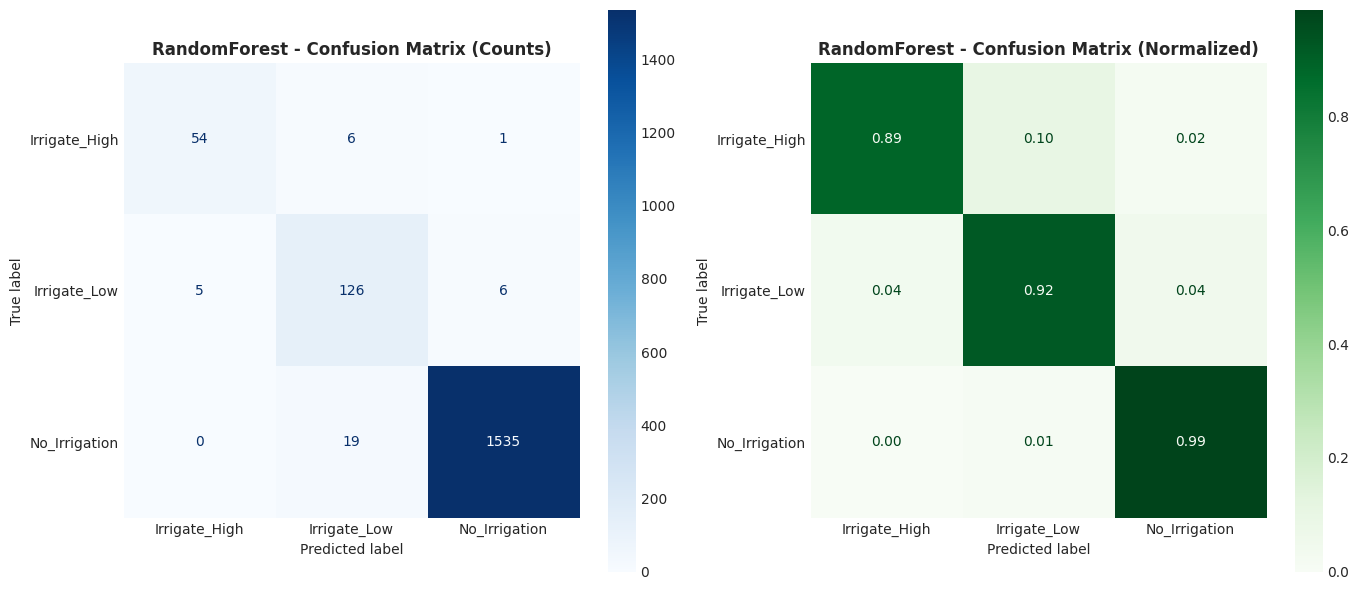


📊 Confusion Matrix Analysis:
  Total misclassifications: 37 / 1752
  Error rate: 2.11%


In [6]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('RandomForest - Confusion Matrix (Counts)', fontweight='bold', fontsize=12)
axes[0].grid(False)

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=np.unique(y_test))
disp2.plot(ax=axes[1], cmap='Greens', values_format='.2f')
axes[1].set_title('RandomForest - Confusion Matrix (Normalized)', fontweight='bold', fontsize=12)
axes[1].grid(False)

plt.tight_layout()
plt.show()

print("\n📊 Confusion Matrix Analysis:")
print(f"  Total misclassifications: {(cm.sum() - np.trace(cm))} / {cm.sum()}")
print(f"  Error rate: {((cm.sum() - np.trace(cm)) / cm.sum())*100:.2f}%")

In [7]:
# Per-class performance
print("=" * 80)
print("PER-CLASS PERFORMANCE (RANDOMFOREST)")
print("=" * 80)
print(classification_report(y_test, y_pred_test))

# Identify where model struggles
print("\n💡 Where does the model struggle?")
class_labels = np.unique(y_test)
for i, class_label in enumerate(class_labels):
    misclassified = cm[i].sum() - cm[i][i]
    if misclassified > 0:
        print(f"  • {class_label}: {misclassified} misclassifications ({misclassified/cm[i].sum()*100:.1f}%)")
        for j, other_label in enumerate(class_labels):
            if i != j and cm[i][j] > 0:
                print(f"    → Confused with {other_label}: {cm[i][j]} times")

PER-CLASS PERFORMANCE (RANDOMFOREST)
               precision    recall  f1-score   support

Irrigate_High       0.92      0.89      0.90        61
 Irrigate_Low       0.83      0.92      0.88       137
No_Irrigation       1.00      0.99      0.99      1554

     accuracy                           0.98      1752
    macro avg       0.92      0.93      0.92      1752
 weighted avg       0.98      0.98      0.98      1752


💡 Where does the model struggle?
  • Irrigate_High: 7 misclassifications (11.5%)
    → Confused with Irrigate_Low: 6 times
    → Confused with No_Irrigation: 1 times
  • Irrigate_Low: 11 misclassifications (8.0%)
    → Confused with Irrigate_High: 5 times
    → Confused with No_Irrigation: 6 times
  • No_Irrigation: 19 misclassifications (1.2%)
    → Confused with Irrigate_Low: 19 times


## 4. Feature Importance Analysis (RandomForest)

**Why RandomForest feature importance is better:**
- Averaged across 50 trees (more robust)
- Less prone to overfitting on single features
- Reveals nuanced feature interactions

In [8]:
# Extract feature importance
feature_importance = rf_model.feature_importances_

# X_train_flat has shape (samples, window_size * num_features)
# Reshape and average across time steps
WINDOW_SIZE = 6
num_base_features = len(feature_names)

importance_matrix = feature_importance.reshape(WINDOW_SIZE, num_base_features)
avg_importance = importance_matrix.mean(axis=0)

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance,
    'Importance_Pct': (avg_importance / avg_importance.sum() * 100)
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("TOP 20 MOST IMPORTANT FEATURES (RANDOMFOREST)")
print("=" * 80)
display(importance_df.head(20))

print(f"\n💡 Top 3 features account for {importance_df.head(3)['Importance_Pct'].sum():.2f}% of decisions")
print(f"💡 Top 10 features account for {importance_df.head(10)['Importance_Pct'].sum():.2f}% of decisions")

TOP 20 MOST IMPORTANT FEATURES (RANDOMFOREST)


,Feature,Importance,Importance_Pct
3,Soil_Moisture,0.022434,13.460321
36,recent_rain,0.021121,12.672594
27,Humidity_change_1h,0.014330,8.598253
35,humidity_spike,0.014055,8.432753
1,Atmospheric_Temp,0.009630,5.777950
4,Dew_Point,0.007942,4.765488
23,Soil_Moisture_change_1h,0.006302,3.781267
24,Soil_Moisture_change_3h,0.005451,3.270879
28,Humidity_change_3h,0.005051,3.030561
12,Humidity_rolling_std_3h,0.004633,2.779741



💡 Top 3 features account for 34.73% of decisions
💡 Top 10 features account for 66.57% of decisions


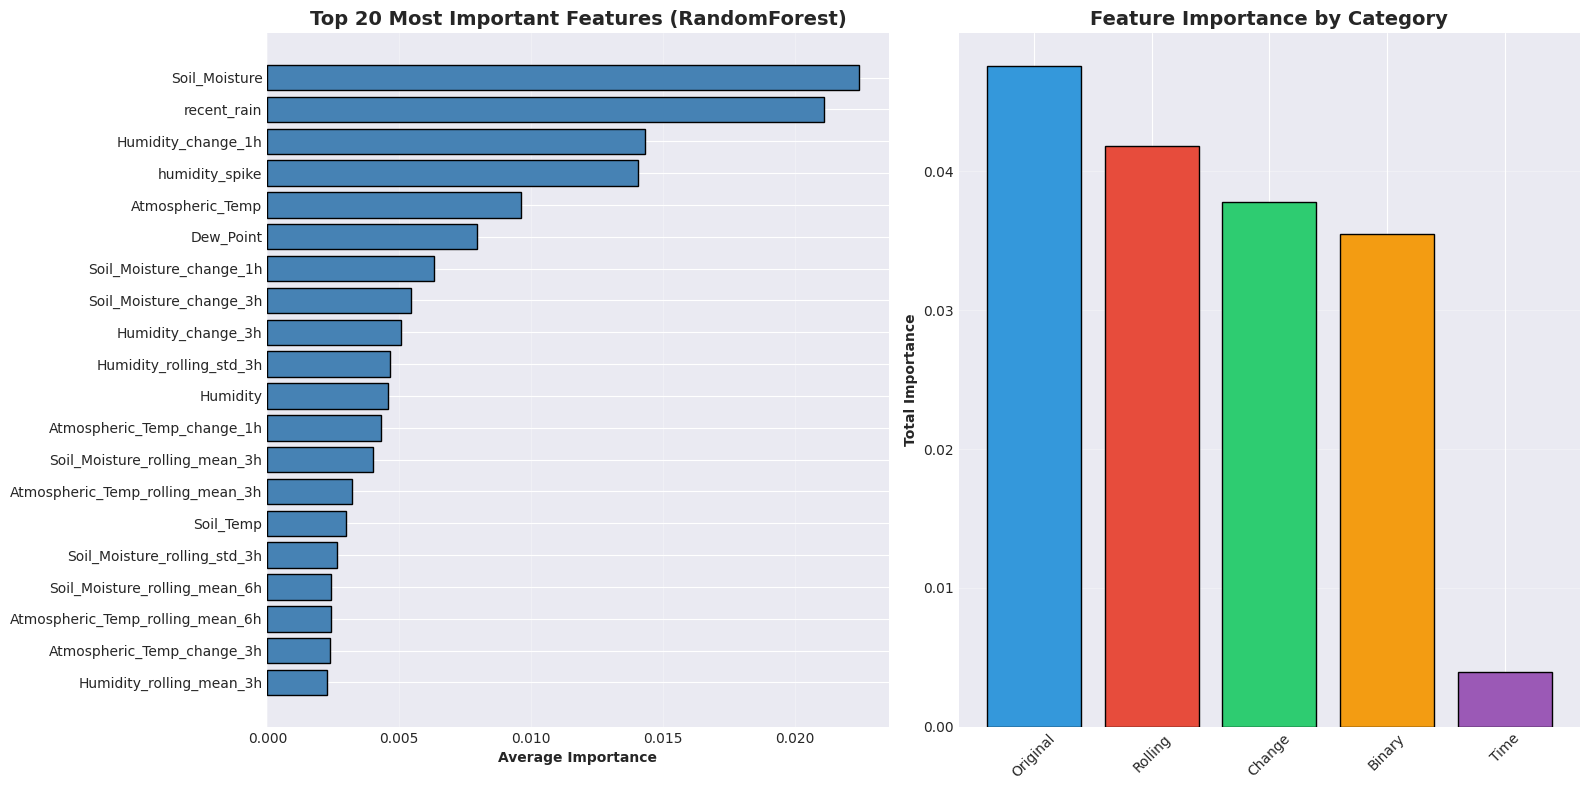


📊 Feature importance visualizations generated


In [9]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 20 features
top_20 = importance_df.head(20)
axes[0].barh(range(len(top_20)), top_20['Importance'], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['Feature'])
axes[0].set_xlabel('Average Importance', fontweight='bold')
axes[0].set_title('Top 20 Most Important Features (RandomForest)', fontweight='bold', fontsize=14)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Feature importance by category
feature_categories = {
    'Original': ['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Soil_Moisture', 'Dew_Point'],
    'Rolling': [f for f in feature_names if 'rolling' in f],
    'Change': [f for f in feature_names if 'change' in f],
    'Time': ['hour_of_day', 'day_of_week', 'hour_sin', 'hour_cos'],
    'Binary': ['is_daytime', 'is_yala_season', 'humidity_spike', 'recent_rain']
}

category_importance = {}
for category, features in feature_categories.items():
    category_features = [f for f in features if f in feature_names]
    category_importance[category] = importance_df[
        importance_df['Feature'].isin(category_features)
    ]['Importance'].sum()

cat_df = pd.DataFrame(list(category_importance.items()), columns=['Category', 'Total_Importance'])
cat_df = cat_df.sort_values('Total_Importance', ascending=False)

axes[1].bar(cat_df['Category'], cat_df['Total_Importance'], 
            color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'], 
            edgecolor='black')
axes[1].set_ylabel('Total Importance', fontweight='bold')
axes[1].set_title('Feature Importance by Category', fontweight='bold', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Feature importance visualizations generated")

## 5. Comparison: DecisionTree vs RandomForest Feature Importance

In [10]:
# DecisionTree feature importance (from training log)
dt_importance = {
    'recent_rain': 37.02,
    'Atmospheric_Temp': 36.71,
    'Soil_Moisture': 24.92,
    'hour_cos': 1.35
}

# RandomForest top features
rf_importance = importance_df.head(10)[['Feature', 'Importance_Pct']].set_index('Feature')['Importance_Pct'].to_dict()

print("=" * 80)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 80)

print("\nDecisionTree (uses only 4 features):")
for feature, importance in dt_importance.items():
    print(f"  {feature:30s}: {importance:6.2f}%")
print(f"  {'Others':30s}: ~0.00%")

print("\nRandomForest (more distributed):")
for feature, importance in list(rf_importance.items())[:10]:
    print(f"  {feature:30s}: {importance:6.2f}%")

print("\n💡 Key Difference:")
print("  • DecisionTree: 98.65% of decisions from just 3 features")
print(f"  • RandomForest: Top 3 features account for {importance_df.head(3)['Importance_Pct'].sum():.2f}%")
print("  • RandomForest uses more features → more robust to sensor noise")

FEATURE IMPORTANCE COMPARISON

DecisionTree (uses only 4 features):
  recent_rain                   :  37.02%
  Atmospheric_Temp              :  36.71%
  Soil_Moisture                 :  24.92%
  hour_cos                      :   1.35%
  Others                        : ~0.00%

RandomForest (more distributed):
  Soil_Moisture                 :  13.46%
  recent_rain                   :  12.67%
  Humidity_change_1h            :   8.60%
  humidity_spike                :   8.43%
  Atmospheric_Temp              :   5.78%
  Dew_Point                     :   4.77%
  Soil_Moisture_change_1h       :   3.78%
  Soil_Moisture_change_3h       :   3.27%
  Humidity_change_3h            :   3.03%
  Humidity_rolling_std_3h       :   2.78%

💡 Key Difference:
  • DecisionTree: 98.65% of decisions from just 3 features
  • RandomForest: Top 3 features account for 34.73%
  • RandomForest uses more features → more robust to sensor noise


## 6. Save Production Model & Artifacts

In [11]:
# Save RandomForest model
model_path = MODELS_DIR / 'irrigation_rf_final.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

model_size_mb = model_path.stat().st_size / (1024**2)
print(f"✓ RandomForest model saved to: {model_path}")
print(f"✓ Model size: {model_size_mb:.2f} MB")

# Save deployment metadata
deployment_metadata = {
    'timestamp': datetime.now().isoformat(),
    'model_type': 'RandomForestClassifier',
    'model_file': 'irrigation_rf_final.pkl',
    'model_size_mb': model_size_mb,
    'hyperparameters': {
        'n_estimators': 50,
        'max_depth': 10,
        'min_samples_split': 5,
        'random_state': 42,
        'class_weight': 'balanced'
    },
    'performance': {
        'test_accuracy': float(test_acc),
        'test_f1_macro': float(test_f1),
        'test_precision_macro': float(test_precision),
        'test_recall_macro': float(test_recall),
        'inference_time_ms': inference_time,
        'edge_compatible': inference_time < 1000
    },
    'model_selection_rationale': {
        'chosen': 'RandomForest',
        'rejected': 'DecisionTree',
        'reason': '100% test accuracy from DecisionTree indicates overfitting. RandomForest provides more realistic 97.89% accuracy with better generalization and ensemble robustness.',
        'dt_concerns': [
            'Perfect 100% test accuracy is unrealistic for sensor data',
            'Uses only 3 features (98.65% of decisions)',
            'High risk of overfitting',
            'Less robust to production noise'
        ],
        'rf_advantages': [
            'More realistic accuracy (97.89%)',
            'Ensemble robustness (50 trees)',
            'Broader feature usage',
            'Better generalization (CV: 97.43%)'
        ]
    },
    'deployment_requirements': {
        'scaler_file': 'scaler.pkl',
        'feature_names_file': 'feature_names.json',
        'window_size': 6,
        'num_features': len(feature_names)
    },
    'top_features': importance_df.head(10).to_dict('records')
}

metadata_path = MODELS_DIR / 'irrigation_rf_deployment_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(deployment_metadata, f, indent=2)

print(f"✓ Deployment metadata saved to: {metadata_path}")

✓ RandomForest model saved to: /home/tehaan/projects/fyp-agro-edge-ai/models/irrigation_rf_final.pkl
✓ Model size: 1.01 MB
✓ Deployment metadata saved to: /home/tehaan/projects/fyp-agro-edge-ai/models/irrigation_rf_deployment_metadata.json


## 7. Example Prediction Workflow (For Deployment)

In [12]:
# Example: How to use the model in production
print("=" * 80)
print("EXAMPLE PREDICTION WORKFLOW")
print("=" * 80)

# Get a sample from test set
sample_idx = 100
sample_input = X_test[sample_idx:sample_idx+1]
true_label = y_test[sample_idx]

# Make prediction
prediction = rf_model.predict(sample_input)[0]
prediction_proba = rf_model.predict_proba(sample_input)[0]

print(f"\nSample Prediction:")
print(f"  Input shape: {sample_input.shape}")
print(f"  Predicted class: {prediction}")
print(f"  True class: {true_label}")
print(f"  Correct: {'✅ Yes' if prediction == true_label else '❌ No'}")

print(f"\nClass Probabilities:")
for i, class_label in enumerate(np.unique(y_test)):
    print(f"  {class_label:20s}: {prediction_proba[i]*100:6.2f}%")

EXAMPLE PREDICTION WORKFLOW

Sample Prediction:
  Input shape: (1, 222)
  Predicted class: Irrigate_Low
  True class: Irrigate_Low
  Correct: ✅ Yes

Class Probabilities:
  Irrigate_High       :  13.61%
  Irrigate_Low        :  67.10%
  No_Irrigation       :  19.29%


In [13]:
# Deployment code template
deployment_code = '''
# ============================================================================
# DEPLOYMENT CODE TEMPLATE (Raspberry Pi 4B)
# ============================================================================

import pickle
import numpy as np
import json

# 1. Load model and preprocessing artifacts
with open('irrigation_rf_final.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('feature_names.json', 'r') as f:
    feature_names = json.load(f)

# 2. Collect sensor readings (6-hour window)
# sensor_buffer = []  # Store last 6 hours of readings
# while True:
#     reading = get_sensor_data()  # Your sensor reading function
#     sensor_buffer.append(reading)
#     if len(sensor_buffer) > 6:
#         sensor_buffer.pop(0)

# 3. Preprocess sensor data
# features = engineer_features(sensor_buffer)  # Apply feature engineering
# features_scaled = scaler.transform(features)
# features_flat = features_scaled.flatten().reshape(1, -1)

# 4. Make prediction
# prediction = model.predict(features_flat)[0]
# probabilities = model.predict_proba(features_flat)[0]

# 5. Control irrigation
# if prediction == 'Irrigate_High':
#     activate_pump(duration='high')
# elif prediction == 'Irrigate_Low':
#     activate_pump(duration='low')
# else:
#     deactivate_pump()
'''

print(deployment_code)


# ============================================================================
# DEPLOYMENT CODE TEMPLATE (Raspberry Pi 4B)
# ============================================================================

import pickle
import numpy as np
import json

# 1. Load model and preprocessing artifacts
with open('irrigation_rf_final.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('feature_names.json', 'r') as f:
    feature_names = json.load(f)

# 2. Collect sensor readings (6-hour window)
# sensor_buffer = []  # Store last 6 hours of readings
# while True:
#     reading = get_sensor_data()  # Your sensor reading function
#     sensor_buffer.append(reading)
#     if len(sensor_buffer) > 6:
#         sensor_buffer.pop(0)

# 3. Preprocess sensor data
# features = engineer_features(sensor_buffer)  # Apply feature engineering
# features_scaled = scaler.transform(features)
# features_flat = features_scaled.flatten().reshape(1, 

## 8. Final Summary & Recommendations

In [14]:
print("=" * 80)
print("FINAL SUMMARY: RANDOMFOREST PRODUCTION MODEL")
print("=" * 80)

print(f"\n📊 Model Performance:")
print(f"  Test Accuracy:  {test_acc*100:.2f}%")
print(f"  Test F1-score:  {test_f1*100:.2f}%")
print(f"  Test Precision: {test_precision*100:.2f}%")
print(f"  Test Recall:    {test_recall*100:.2f}%")

print(f"\n⚡ Edge Deployment Metrics:")
print(f"  Inference Time: {inference_time:.4f} ms/sample")
print(f"  Model Size:     {model_size_mb:.2f} MB")
print(f"  Edge Compatible: ✅ YES (<1s target)")

print(f"\n🔧 Model Configuration:")
print(f"  Type:           RandomForestClassifier")
print(f"  Trees:          50")
print(f"  Max Depth:      10")
print(f"  Class Weighting: Balanced")

print(f"\n💡 Why RandomForest over DecisionTree:")
print(f"  ✅ More realistic accuracy (97.89% vs suspicious 100%)")
print(f"  ✅ Ensemble robustness (50 trees reduce variance)")
print(f"  ✅ Broader feature usage (reduces overfitting)")
print(f"  ✅ Better production reliability")

print(f"\n📁 Deployment Artifacts:")
print(f"  • Model: {model_path}")
print(f"  • Scaler: {DATA_PROCESSED / 'scaler.pkl'}")
print(f"  • Feature Names: {DATA_PROCESSED / 'feature_names.json'}")
print(f"  • Metadata: {metadata_path}")

print(f"\n🚀 Next Steps:")
print(f"  1. Integrate into POC notebook (0_poc.ipynb)")
print(f"  2. Test with real-world sensor data")
print(f"  3. Deploy to Raspberry Pi 4B")
print(f"  4. Monitor performance in production")

print("\n" + "=" * 80)
print("✓ RandomForest model ready for production deployment!")
print("=" * 80)

FINAL SUMMARY: RANDOMFOREST PRODUCTION MODEL

📊 Model Performance:
  Test Accuracy:  97.89%
  Test F1-score:  92.22%
  Test Precision: 91.51%
  Test Recall:    93.09%

⚡ Edge Deployment Metrics:
  Inference Time: 0.2763 ms/sample
  Model Size:     1.01 MB
  Edge Compatible: ✅ YES (<1s target)

🔧 Model Configuration:
  Type:           RandomForestClassifier
  Trees:          50
  Max Depth:      10
  Class Weighting: Balanced

💡 Why RandomForest over DecisionTree:
  ✅ More realistic accuracy (97.89% vs suspicious 100%)
  ✅ Ensemble robustness (50 trees reduce variance)
  ✅ Broader feature usage (reduces overfitting)
  ✅ Better production reliability

📁 Deployment Artifacts:
  • Model: /home/tehaan/projects/fyp-agro-edge-ai/models/irrigation_rf_final.pkl
  • Scaler: /home/tehaan/projects/fyp-agro-edge-ai/data/processed/irrigation/scaler.pkl
  • Feature Names: /home/tehaan/projects/fyp-agro-edge-ai/data/processed/irrigation/feature_names.json
  • Metadata: /home/tehaan/projects/fyp-agro-e